In [37]:
from sklearn.model_selection import TimeSeriesSplit

import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM
from sklearn.metrics import r2_score

# XGBoost import
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import pickle

# grid_cv import
from sklearn.model_selection import GridSearchCV

# 최대 재귀함수 깊이 설정
import sys
sys.setrecursionlimit(10**7)

# timedelta import
from datetime import timedelta

# datetime import
from datetime import datetime

# mdates import
import matplotlib.dates as mdates

# RandomForestRegressor import
from sklearn.ensemble import RandomForestRegressor


In [23]:
df= pd.read_csv('data/price/price_baechoo.csv')
# df 구분 인덱스로 설정
df.set_index('구분', inplace=True)

# 평균 컬럼 가격 컬럼으로 변경
df.rename(columns={'평균':'가격'}, inplace=True)

df

,가격
구분,
2000-01-03,5600.0
2000-01-04,5600.0
2000-01-05,5620.0
2000-01-06,5700.0
2000-01-07,5670.0
...,...
2022-12-14,5430.5
2022-12-15,5430.5
2022-12-16,5304.0


In [25]:
# 시가, 고가, 저가, 종가 컬럼 생성하여 새로운 데이터프레임 생성
df2 = pd.DataFrame(columns=['시가', '고가', '저가', '종가'])

# df에 인덱스를 추출하여 리스트로 변환
idx = df.index.tolist()

# idx를 앞에 5일 단위로 슬라이싱
idx = idx[::5]

# idx를 df2에 추가
df2['구분'] = idx
# df2 구분 인덱스로 설정
df2.set_index('구분', inplace=True)
df2

# df2 2000-01-08 ~ 2020-12-31 까지 반복문을 통해 '시가' = 5일 전, '고가' = 5일 전 ~ 1일 전, '저가' = 5일 전 ~ 1일 전, '종가' = 1일 전
for i in range(1, len(df2)):
    df2.loc[df2.index[i]] = [df.loc[df2.index[i-1]]['가격'], df.loc[df2.index[i-1]:df2.index[i]]['가격'].max(), df.loc[df2.index[i-1]:df2.index[i]]['가격'].min(), df.loc[df2.index[i]]['가격']]

# df2 결측치 제거
df2.dropna(inplace=True)

# df2 데이터 타입 변환
df2 = df2.astype('float64')

df2

,시가,고가,저가,종가
구분,,,,
2000-01-08,5600.0,5770.0,5600.0,5770.0
2000-01-14,5770.0,5790.0,5630.0,5630.0
2000-01-20,5630.0,5850.0,5630.0,5850.0
2000-01-26,5850.0,5930.0,5850.0,5930.0
2000-02-01,5930.0,6690.0,5930.0,6690.0
...,...,...,...,...
2022-11-15,7193.5,7193.5,6684.0,6684.0
2022-11-22,6684.0,7018.0,6260.0,6260.0
2022-11-29,6260.0,6260.0,5592.0,5592.0


In [26]:
# df2에 종가_shift 컬럼 생성
df2['종가_shift'] = df2['종가'].shift(-1)

df2

,시가,고가,저가,종가,종가_shift
구분,,,,,
2000-01-08,5600.0,5770.0,5600.0,5770.0,5630.0
2000-01-14,5770.0,5790.0,5630.0,5630.0,5850.0
2000-01-20,5630.0,5850.0,5630.0,5850.0,5930.0
2000-01-26,5850.0,5930.0,5850.0,5930.0,6690.0
2000-02-01,5930.0,6690.0,5930.0,6690.0,7230.0
...,...,...,...,...,...
2022-11-15,7193.5,7193.5,6684.0,6684.0,6260.0
2022-11-22,6684.0,7018.0,6260.0,6260.0,5592.0
2022-11-29,6260.0,6260.0,5592.0,5592.0,5488.0


In [32]:
# 결측치 제거
df2.dropna(inplace=True)
df2

,시가,고가,저가,종가,종가_shift
구분,,,,,
2000-01-08,5600.0,5770.0,5600.0,5770.0,5630.0
2000-01-14,5770.0,5790.0,5630.0,5630.0,5850.0
2000-01-20,5630.0,5850.0,5630.0,5850.0,5930.0
2000-01-26,5850.0,5930.0,5850.0,5930.0,6690.0
2000-02-01,5930.0,6690.0,5930.0,6690.0,7230.0
...,...,...,...,...,...
2022-11-08,7350.0,7381.5,6835.5,7193.5,6684.0
2022-11-15,7193.5,7193.5,6684.0,6684.0,6260.0
2022-11-22,6684.0,7018.0,6260.0,6260.0,5592.0


/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


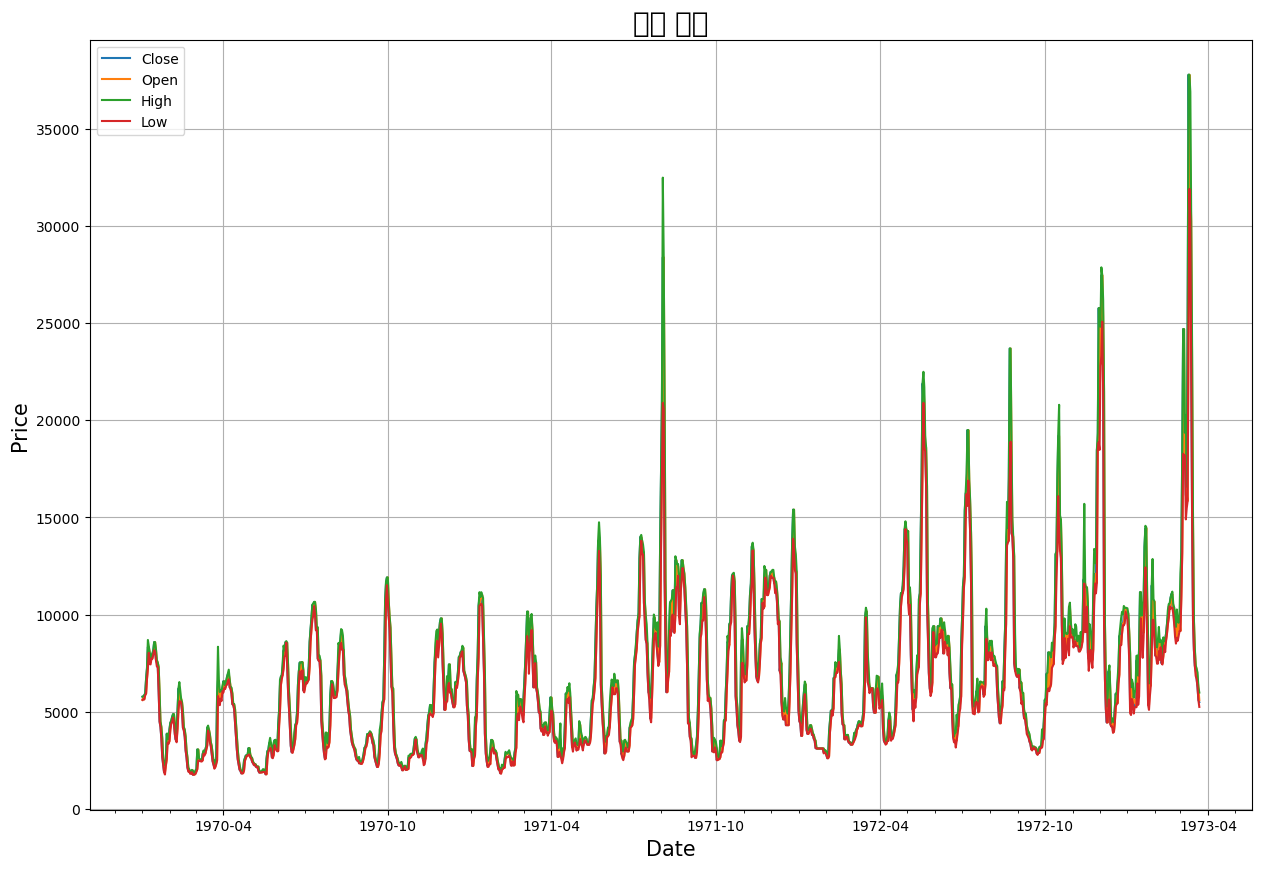

In [35]:
# make candle bar chart function using df2
def make_candle_chart(df2, title):
    # candle chart
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Date', fontsize=15)
    ax.set_ylabel('Price', fontsize=15)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
    ax.grid(True)
    ax.plot(df2.index, df2['종가'], label='Close')
    ax.plot(df2.index, df2['시가'], label='Open')
    ax.plot(df2.index, df2['고가'], label='High')
    ax.plot(df2.index, df2['저가'], label='Low')
    ax.legend()
    plt.show()

# make candle bar chart
make_candle_chart(df2, '배추 가격')



In [36]:
# df2를 train, test 데이터로 분리 (train: 2000부터 2022-10, test: 2022-11)
train = df2.loc['2000-01-01':'2022-10-31']
test = df2.loc['2022-11-01':]

train

,시가,고가,저가,종가,종가_shift
구분,,,,,
2000-01-08,5600.0,5770.0,5600.0,5770.0,5630.0
2000-01-14,5770.0,5790.0,5630.0,5630.0,5850.0
2000-01-20,5630.0,5850.0,5630.0,5850.0,5930.0
2000-01-26,5850.0,5930.0,5850.0,5930.0,6690.0
2000-02-01,5930.0,6690.0,5930.0,6690.0,7230.0
...,...,...,...,...,...
2022-09-23,31920.0,36920.0,30250.0,30250.0,22620.0
2022-09-30,30250.0,30250.0,22620.0,22620.0,14740.0
2022-10-11,22620.0,23500.0,14740.0,14740.0,9706.0


In [47]:
# train 데이터를 X_train, y_train으로 분리
X_train = train.drop('종가_shift', axis=1)
y_train = train['종가_shift']

# test 데이터를 X_test, y_test으로 분리
X_test = test.drop('종가_shift', axis=1)
y_test = test['종가_shift']



array([7470.56 , 6677.945, 6822.505, 6479.17 , 4960.7  , 5502.47 ])